In [1]:
from importlib import reload

import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

sys.path.append(parent_dir)

import src
reload(src)

from src.utils import load_MNIST_data
from src.model import Simple_Model
from src.train import train_model
from src.inference import evaluate_overall, evaluate_classwise, confusion_matrix_plot, plot_roc_curves

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt



In [2]:

print(torch.__version__)
print(torch.backends.mps.is_built())      # Should be True
print(torch.backends.mps.is_available())  # Should now be True

2.8.0
True
True


In [3]:
train_dloader, val_dloader, test_dloader = load_MNIST_data(batch_size = 128, num_workers=4) # try increase batch size to 128

In [10]:
device = torch.device("mps")
print(f"Using device: {device}")

CNN_model = Simple_Model(out_channels = 6, 
                         kernel_size = 5)


loss_fcn = nn.CrossEntropyLoss(reduction='sum')
optimiser = torch.optim.SGD(params = CNN_model.parameters(), lr = 0.001, momentum = 0.9)

for epoch in range(2):
    train_loss, val_loss, val_acc = train_model(CNN_model, optimiser, loss_fcn, train_dloader, val_dloader, epoch, device, print_training = True)

    



Using device: mps


[Epoch  1] Training accuracy: 80.03%, Validation accuracy: 83.35%


[Epoch  2] Training accuracy: 84.14%, Validation accuracy: 82.92%


In [11]:
test_acc = evaluate_overall(CNN_model, test_dloader, device)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.8270


In [12]:
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

In [13]:
classwise_acc = evaluate_classwise(CNN_model, test_dloader, device, class_names)
for classname, acc in classwise_acc.items():
    print(f"Class: {classname}  Accuracy: {acc:.4f}")

Class: T-shirt/top  Accuracy: 0.8650
Class: Trouser  Accuracy: 0.9300
Class: Pullover  Accuracy: 0.8480
Class: Dress  Accuracy: 0.8960
Class: Coat  Accuracy: 0.7220
Class: Sandal  Accuracy: 0.9630
Class: Shirt  Accuracy: 0.2660
Class: Sneaker  Accuracy: 0.8870
Class: Bag  Accuracy: 0.9360
Class: Ankle boot  Accuracy: 0.9570


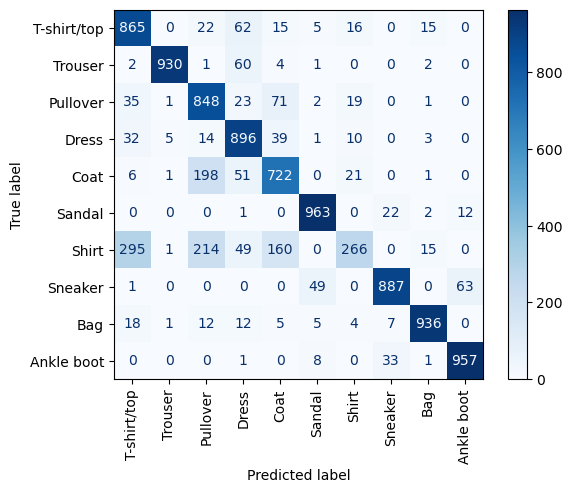

In [14]:
confusion_matrix = confusion_matrix_plot(CNN_model, test_dloader, device, class_names)

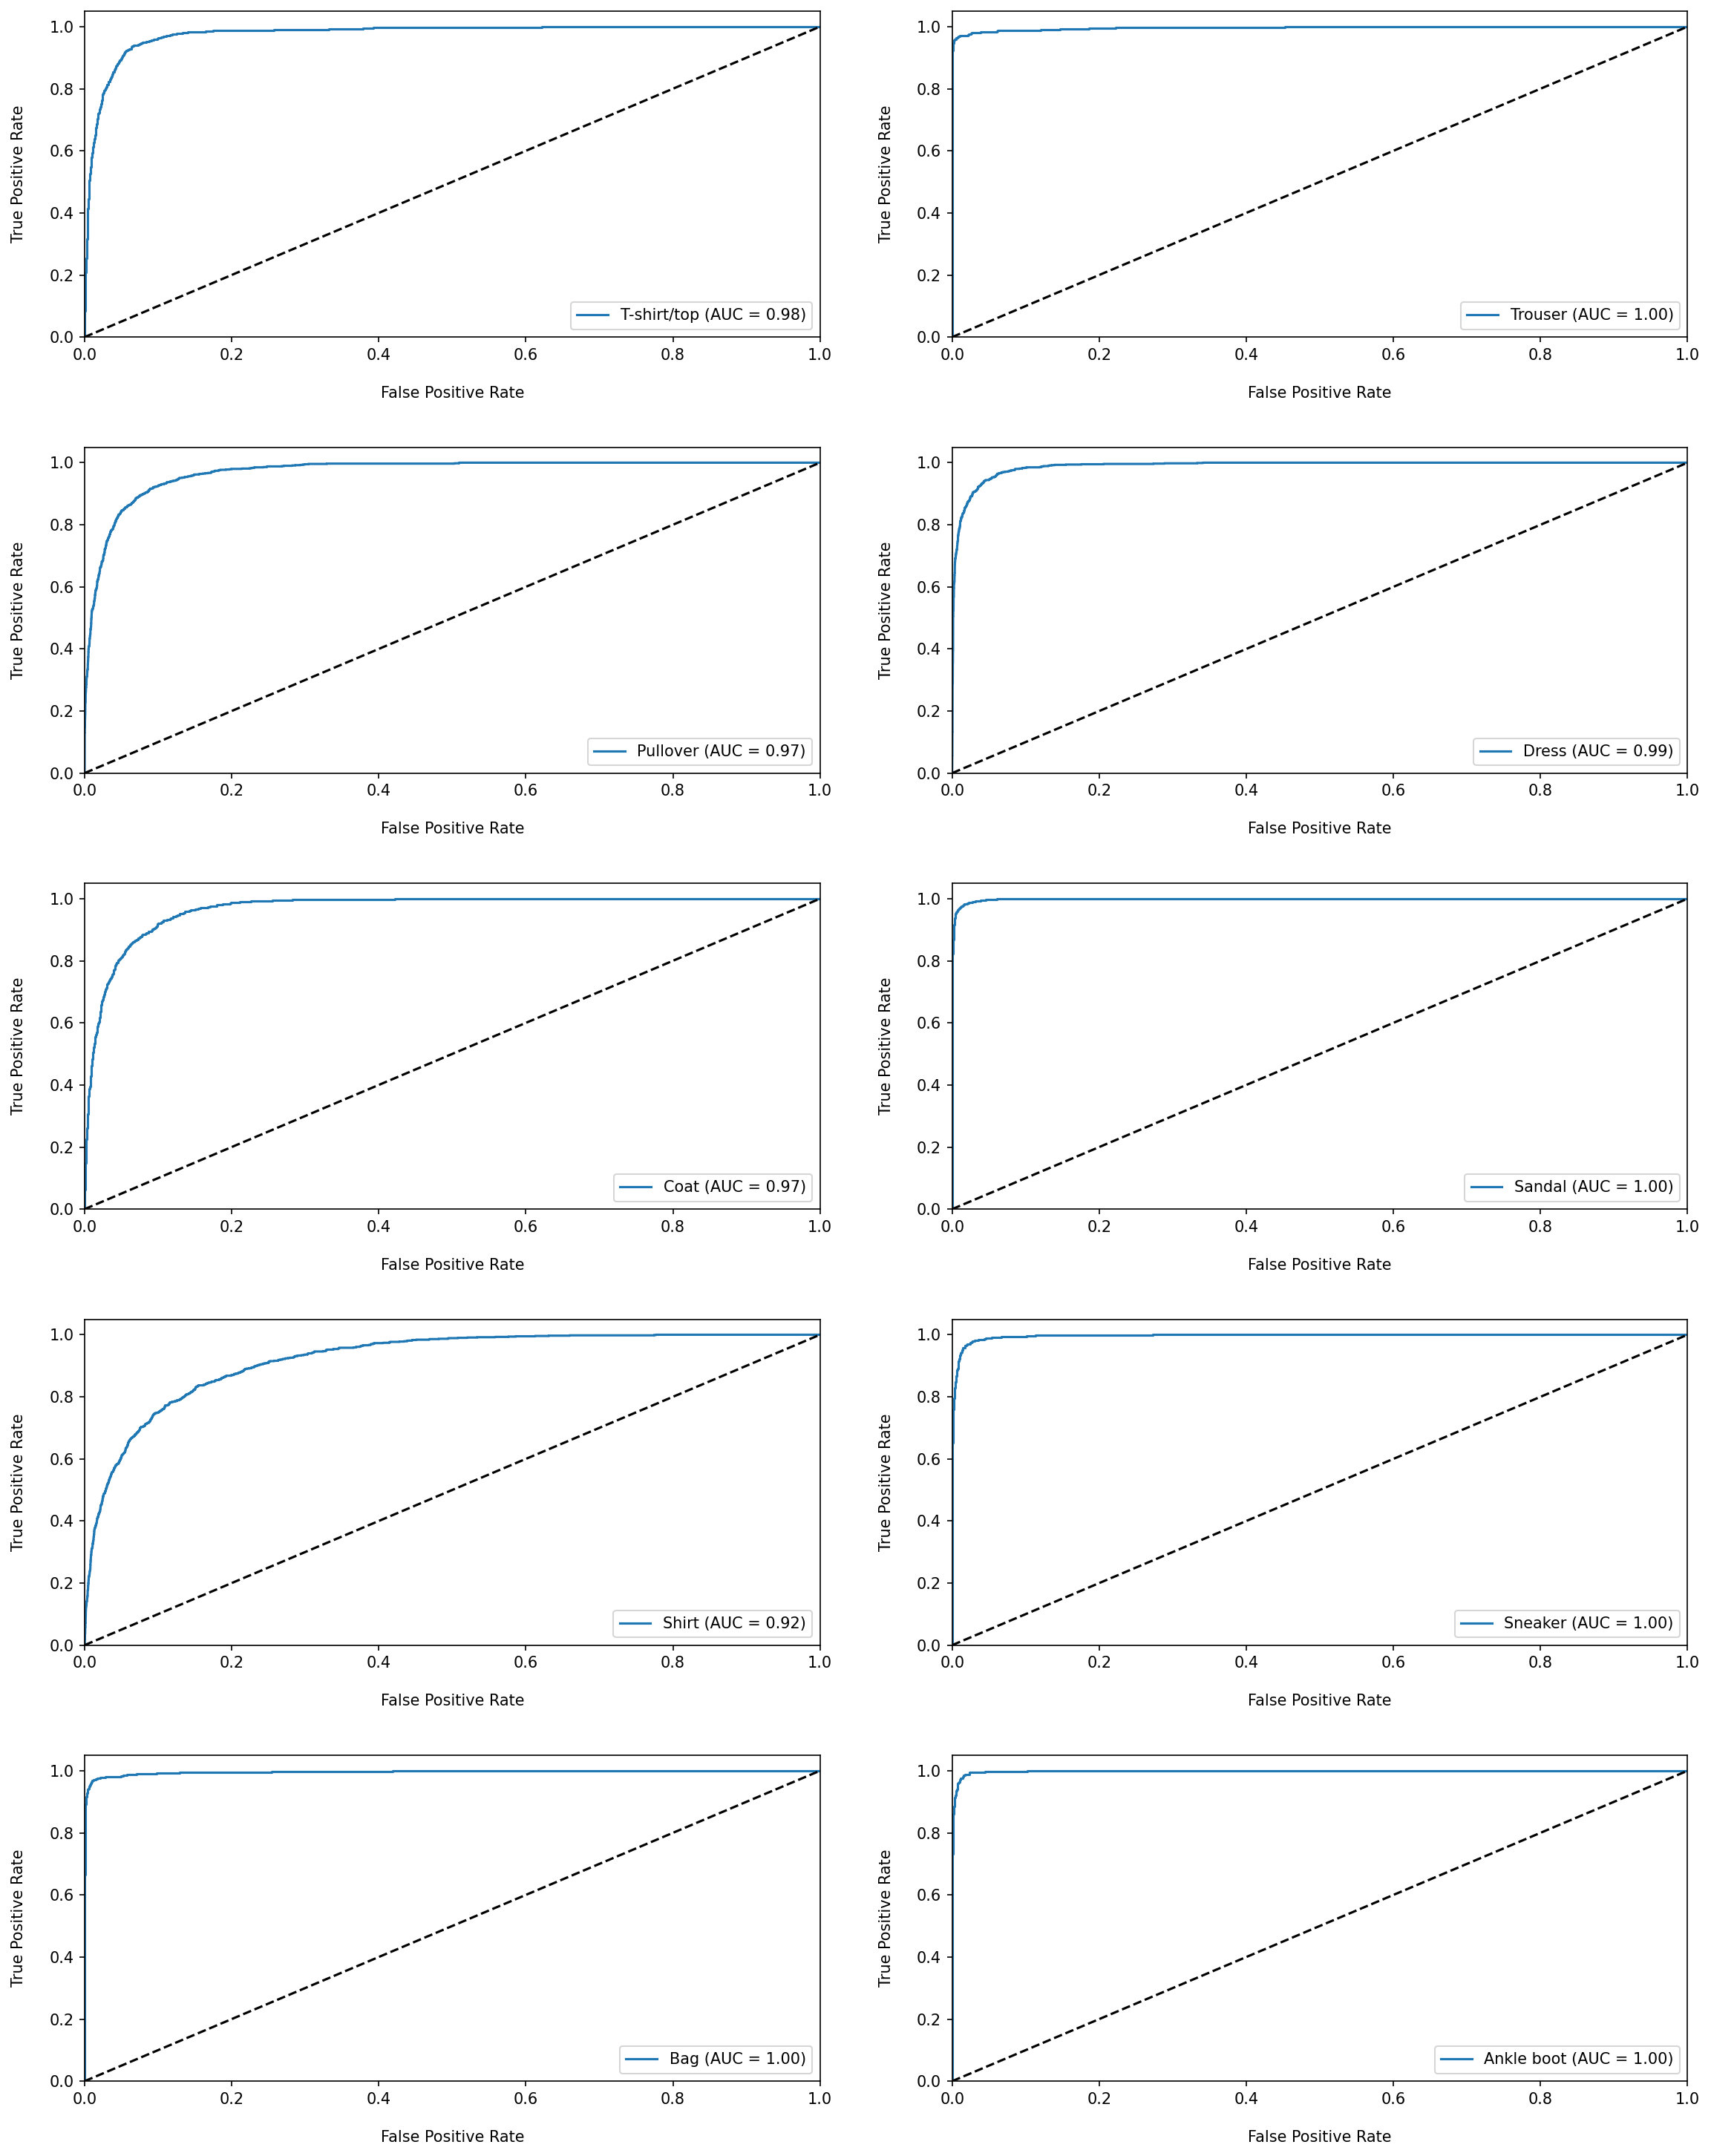

In [15]:
fig = plot_roc_curves(CNN_model, test_dloader, device, class_names)
plt.show()